<a href="https://colab.research.google.com/github/darkosisak/WQU-Group12-Capstone/blob/master/Capstone_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Appendix: the Python code
The following represents the actionable Python code used in this project.

Acknowledgements: Hudson & Thames (Jaques Joubert), Decisive Alpha (Lionel Young)


In [0]:
!pip install pyfolio
!pip install yfinance
!pip install mlfinlab
!pip install decisiveml

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pyfolio as pf
import mlfinlab as ml

# trendscanning
import sys
sys.path.append("..")
import decisiveml as dml

from numpy import array

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from mlfinlab.filters import filters
from mlfinlab.labeling import labeling
#from mlfinlab.util import utils                        # deprecated

from mlfinlab.sampling import concurrent
from mlfinlab.sampling import bootstrapping
from mlfinlab.util import multiprocess

% matplotlib inline

/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [3]:
# loading data
r = pd.read_csv('https://capital20.com/WQU_CapstoneData/GBPUSD_TickBar_500_Bid_2019.01.02_2020.05.13.csv')

r.index = pd.to_datetime(r['Time (UTC)'])
r = r.drop(['Time (UTC)', 'EndTime'], axis=1)
prices = r["Close"] 

###############################################################################
# Features 1: Technical indicators
###############################################################################

def moving_average(x, n, type='simple'):
    """
    computing an n period moving average.
    type is 'simple' | 'exponential'
    """
    x = np.asarray(x)
    if type == 'exponential':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()

    a = np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a

def relative_strength(prices, n=14):
    """
    computing the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """

    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100. / (1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # because the diff is 1 shorter!

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n

        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)
    return rsi


def moving_average_convergence(x, nslow, nfast):
    """
    computing the MACD (Moving Average Convergence/Divergence) using a fast and
    slow exponential moving avg
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    return emaslow, emafast, emafast - emaslow


def bbands(close_prices, window, no_of_stdev):
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band


def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=14):
    data = r.copy()
    high = r['High']
    low = r['Low']
    close = r['Close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    atrx = atr*2
    return atr, atrx
  
# computing RSI
r['rsi'] = relative_strength(r['Close'], 14)

# computing BB
r['BBmid'], r['BBup'], r['BBlo'] = bbands(r['Close'], 20, no_of_stdev=2)

# computing the MACD indicator
nslow = 48
nfast = 26
nema = 20
emaslow, emafast, macd = moving_average_convergence(prices, nslow=nslow, nfast=nfast)
r['MACD'] = macd
r['MACD_sig'] = moving_average(r['MACD'], nema, type='exponential')

# computing the MAs
ma20 = moving_average(prices, 25, type='simple')
ma60 = moving_average(prices, 130, type='exponential')
ma200 = moving_average(prices, 200, type='simple')

# computing the ATRs
r['ATR'], r['ATRx'] = (atr(r['Close'], 7))

###############################################################################
# Signalling
###############################################################################

#### ATR DIRECTION
r['atr_dir'] = 0 
short_atr_dir = ((r['Close'] <= (r['Close'].shift(1) + r['ATRx'])) & (r['Close'].shift(1) > (r['Close'].shift(2) + r['ATRx'])))
long_atr_dir = ((r['Close'] > (r['Close'].shift(1) - r['ATRx'])) & (r['Close'].shift(1) <= (r['Close'].shift(2) - r['ATRx'])))
r.loc[long_atr_dir, 'atr_dir'] = 1
r.loc[short_atr_dir, 'atr_dir'] = -1

#### MICRO-BREAKOUT
r['mbo'] = 0 
long_mbo = (r['High'] > r['High'].shift(1))
short_mbo = (r['Low'] < r['Low'].shift(1)) 
r.loc[long_mbo, 'mbo'] = 1
r.loc[short_mbo, 'mbo'] = -1
"""
#### RETRACEMENT
r['rtm'] = np.nan 
long_rtm = ((r['Low'].shift(-1) < r['BBmid'].shift(-1)) &  (ma20 > ma60))  
short_rtm = ((r['High'].shift(-1) > r['BBmid'].shift(-1)) & (ma20 <= ma60)) 
r.loc[long_rtm, 'rtm'] = 1
r.loc[short_rtm, 'rtm'] = -1

#### BOUNCE
r['bou'] = np.nan 
long_bou = ((r['Close'] > r['Open']) & (ma20 > ma60))  
short_bou = ((r['Close'] < r['Open']) & (ma20 <= ma60)) 
r.loc[long_bou, 'bou'] = 1
r.loc[short_bou, 'bou'] = -1
"""
#### RETRACEMENT BOUNCE
r['rbo'] = np.nan           # not = 0, because we want to filter out all non-events to implement intrinsic time
long_rbo = ((r['Low'].shift(1) < r['BBmid'].shift(1)) & (r['Close'] > r['Open']) & (ma20 > ma60))  
short_rbo = ((r['High'].shift(1) > r['BBmid'].shift(1)) & (r['Close'] < r['Open']) & (ma20 <= ma60)) 
r.loc[long_rbo, 'rbo'] = 1
r.loc[short_rbo, 'rbo'] = -1

##### SIDES
r['BB_sides'] = 0 
long_signals = (r['Close'] <= r['BBlo']) 
short_signals = (r['Close'] >= r['BBup']) 
r.loc[long_signals, 'BB_sides'] = 1
r.loc[short_signals, 'BB_sides'] = -1

#### MA SIDE
r['dir'] = 0 
short_dir = (ma20 <= ma60) 
long_dir = (ma20 > ma60) 
r.loc[long_dir, 'dir'] = 1
r.loc[short_dir, 'dir'] = -1

#### OVERSOLD/OVERBOUGHT
r['over'] = 0 
oversold = (r['rsi'] <= 30) 
overbought = (r['rsi'] >= 70) 
r.loc[overbought, 'over'] = 1
r.loc[oversold, 'over'] = -1

#### BB STRETCH
r['BB_vol'] = 0 
not_oversold = (r['Close'] >= r['BBlo']) 
not_overbought = (r['Close'] <= r['BBup']) 
r.loc[not_oversold, 'BB_vol'] = -1
r.loc[not_overbought, 'BB_vol'] = 1

#### MACD MOMENTUM
r['MACD_mom'] = 0 
down = (r['MACD'] <= r['MACD_sig']) 
up = (r['MACD'] > r['MACD_sig']) 
r.loc[up, 'MACD_mom'] = 1
r.loc[down, 'MACD_mom'] = -1

# Remove Look ahead bias by lagging the signal
r['dir'] = r['dir'].shift(1)
r['atr_dir'] = r['atr_dir'].shift(1)
r['rbo'] = r['rbo'].shift(1)
r['over'] = r['over'].shift(1)
r['MACD_mom'] = r['MACD_mom'].shift(1)
r['BB_vol'] = r['BB_vol'].shift(1)
r['BB_sides'] = r['BB_sides'].shift(1)

print("ATR Direction:")
print(r.atr_dir.value_counts())
print("\n MA Direction:")
print(r.dir.value_counts())
print("\n Retracement Bounces:")
print(r.rbo.value_counts())
print("\n Micro-Breakouts:")
print(r.mbo.value_counts())
print("\n Oversold/overbought:")
print(r.over.value_counts())
print("\n BB Volatility:")
print(r.BB_vol.value_counts())
print("\n MACD momentum:")
print(r.MACD_mom.value_counts())
print("\n BB Sides:")
print(r.BB_sides.value_counts())


ATR Direction:
 0.0    86708
 1.0      162
-1.0      155
Name: atr_dir, dtype: int64

 MA Direction:
-1.0    44684
 1.0    42341
Name: dir, dtype: int64

 Retracement Bounces:
-1.0    13050
 1.0    12397
Name: rbo, dtype: int64

 Micro-Breakouts:
-1    41526
 1    33187
 0    12313
Name: mbo, dtype: int64

 Oversold/overbought:
 0.0    80346
-1.0     3367
 1.0     3312
Name: over, dtype: int64

 BB Volatility:
 1.0    86573
-1.0      451
 0.0        1
Name: BB_vol, dtype: int64

 MACD momentum:
-1.0    43579
 1.0    43446
Name: MACD_mom, dtype: int64

 BB Sides:
 0.0    86111
 1.0      463
-1.0      451
Name: BB_sides, dtype: int64


In [0]:
###############################################################################
# Features 2: More features
###############################################################################
# Log Returns
r['log_ret'] = np.log(r['Close']).diff()

# Momentum
r['mom1'] = r['Close'].pct_change(periods=1)

# Volatility
window_stdev = 50
r['vol_50'] = r['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation
window_autocorr = 50
r['autocorr_1'] = r['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)

# Backing up full features dataframe
r_bck = r.copy()

In [0]:
# Loading from backup (optional, for example for re-runs)
r = r_bck.copy()
r["trend"] = trend.bin  

In [0]:
##############################################################################
# Trend Scanning
###############################################################################
trend = dml.getBinsFromTrend(
    molecule=r["rbo"].dropna().index, 
    close=r.Close, 
    span=[22, 44, 11],)

r["trend"] = trend.bin 

# Labeling non-trends with 0
end = trend.t1
r.loc[end, "trend"] = 0
r.trend.fillna(method="ffill", inplace=True)
r.trend.fillna(0, inplace=True)

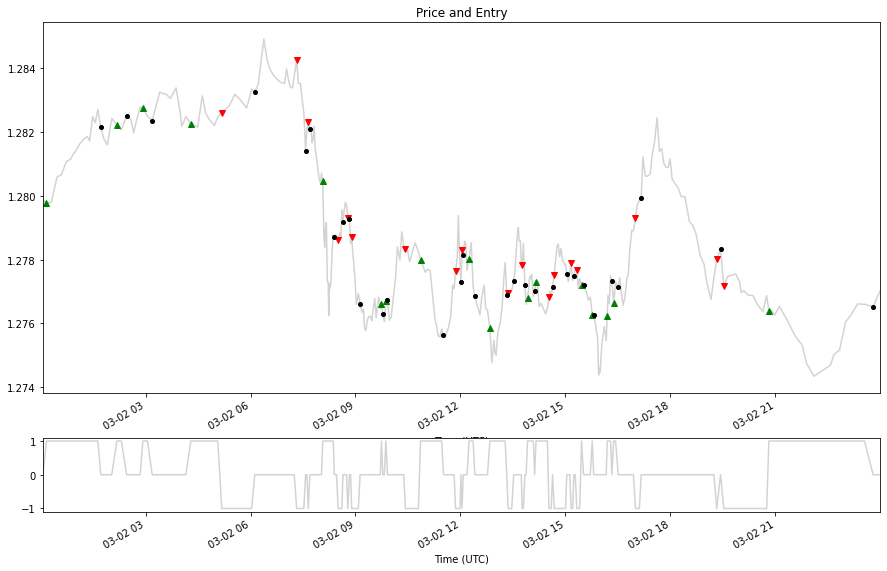

In [8]:
# Trend Scanning visualisation
warnings.filterwarnings("ignore")            # optional, to get rid of the temporary matplotlib warning

fig, axes = plt.subplots(nrows=2, ncols=1, 
                         figsize=(15,10), 
                         gridspec_kw={'height_ratios': [5,1]})

rs = r['2020-03-02':'2020-03-02'].copy()      # picking one day only, for chart readability

# get the unfiltered trends
rs["trendlong"] = r[(r.trend == 1) & (r.trend.shift(1) != 1)].Close
rs["trendshort"] = r[(r.trend == -1) & (r.trend.shift(1) != -1)].Close
rs["trendend"] = r[(r.trend == 0) & (r.trend.shift(1) != 0)].Close
#rs.Close.plot(color="gray")

rs.Close.plot(ax=axes[0], color="lightgray")
#r.entry.plot(ax=axes[0], marker=".", color="gray")
rs.trendlong.plot(ax=axes[0], marker="^", markersize=6, color="green")
rs.trendshort.plot(ax=axes[0], marker="v", markersize=6, color="red")
rs.trendend.plot(ax=axes[0], marker="o", markersize=4, color="black")

rs.trend.plot(ax=axes[1], color="lightgray")

axes[0].title.set_text('Price and Entry')
#axes[1].title.set_text('Trend')

#r.drop(['trendstart', 'trendend'], axis=1, inplace=True)

In [9]:
###############################################################################
# Triple Barrier Labeling
###############################################################################
# Creating a separate set for TB labelling
data = r.copy()
data.dropna(axis=0, how='any', inplace=True)

# computing daily volatility
daily_vol = ml.util.get_daily_vol(close=data['Close'], lookback=50)       # the original idea from MLdP
daily_vol2 = data['ATR']                                                  # like this more, settings for ATR are in above section Features 1

# applying Symmetric CUSUM Filter and getting timestamps for events given the daily volatility
#cusum_events = filters.cusum_filter(data['Close'], threshold = daily_vol['2019-01-02':].mean()*0.04)     # the original idea from MLdP
cusum_events = filters.cusum_filter(data['Close'], threshold = daily_vol2)                                # dynamic volatility, instead the original static mean

# compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(t_events = cusum_events, close=data['Close'], num_hours=6)

pt_sl = [1, 2]
min_ret = 0.0005 
triple_barrier_events = labeling.get_events(close=data['Close'],
                                            t_events=cusum_events,
                                            pt_sl=pt_sl,
                                            target=daily_vol2,
                                            min_ret=min_ret,
                                            num_threads=3,
                                            vertical_barrier_times=False,               # to enable vertical barriers, put vertical_barriers
                                            side_prediction=data['mbo'])                # Here we choose one of the signals for the primary model 
# labeling
labels = ml.labeling.get_bins(triple_barrier_events, data['Close'])
labels.side.value_counts()

2020-05-21 12:55:31.266217 100.0% apply_pt_sl_on_t1 done after 0.14 minutes. Remaining 0.0 minutes.


-1.0    3048
 1.0    2332
Name: side, dtype: int64

In [10]:
###############################################################################
# Primary Model Forecast
###############################################################################
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2520
           1       0.53      1.00      0.69      2860

    accuracy                           0.53      5380
   macro avg       0.27      0.50      0.35      5380
weighted avg       0.28      0.53      0.37      5380

Confusion Matrix
[[   0 2520]
 [   0 2860]]

Accuracy
0.5315985130111525


In [11]:
###############################################################################
# Preparing Features Data
###############################################################################
X = r.loc[labels.index, :]
# dropping unwanted columns
X.drop(['BBmid', 'BBup','BBlo','Open',  'over', 'BB_vol',
        'dir', #'atr_dir', 
        #'trend', 
        #'mbo',
        #'MACD_mom', 
        'High', 'Low', 'Close', 'ATRx', 'log_ret', 'rbo', 
        'MACD', 'rsi', 'vol_50', 'mom1', #'autocorr_1',
        #'mom2','mom3', 'mom4','mom5', 
        #'vol_13', 'vol_7', 'log_t2', 'log_t3', 'log_t4', 'log_t5',
        'MACD_sig'], axis=1, inplace=True)
y = labels['bin']
y.value_counts()

1    2860
0    2520
Name: bin, dtype: int64

In [0]:
###############################################################################
# In-Sample training and testing
###############################################################################
# splitting data into training and validation (test) sets
X_training_validation = X['2019-01-02':'2019-12-31']
y_training_validation = y['2019-01-02':'2019-12-31']
X_train, X_test, y_train, y_test = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)
train_df = pd.concat([y_train, X_train], axis=1, join='inner')


# Upsample the training data to have a 50 - 50 split 
# https://elitedatascience.com/imbalanced-classes

# ----------------------------- Not needed! We will address this later, in RF
"""
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)
"""
train_df['bin'].value_counts()

# Creating training data
X_train = train_df.loc[:, train_df.columns != 'bin']
y_train = train_df['bin']

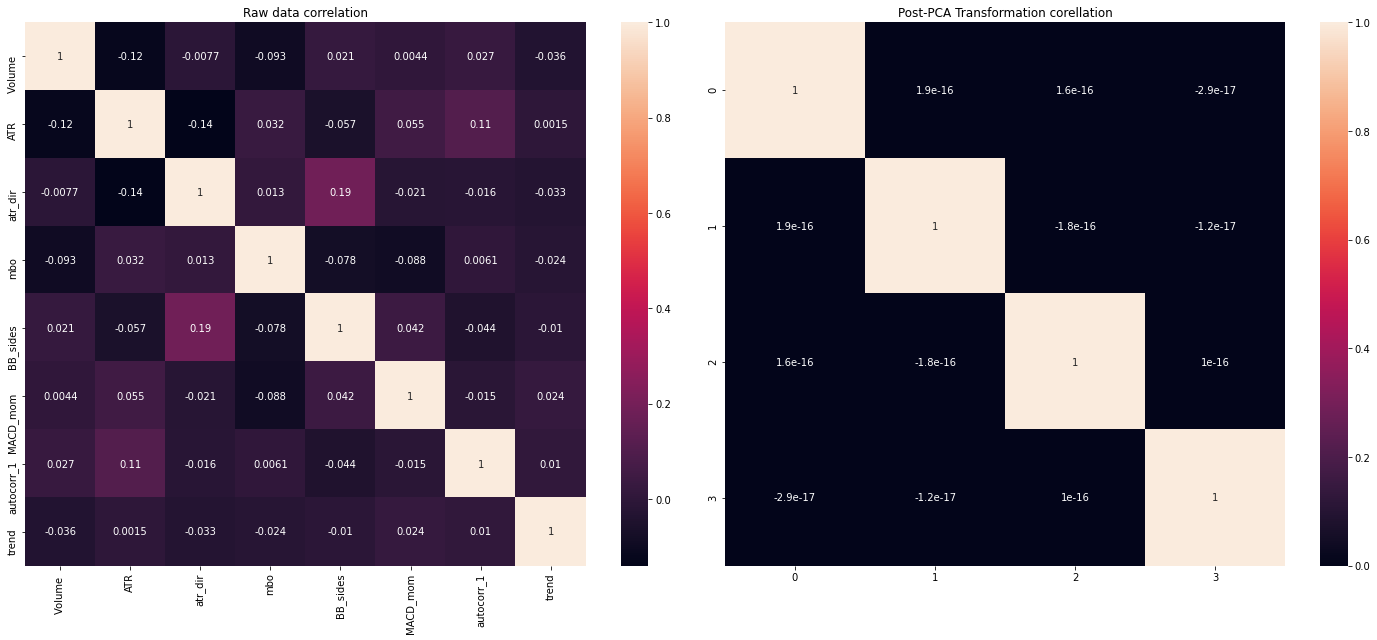

In [13]:
###############################################################################
# Principal Component Analysis
###############################################################################
def preprocessing_transformation(X_train,X_test):
    #imputer = preprocessing.Imputer() # deprecated, using SimpleImputer instead
    imputer = SimpleImputer() 
    scaler = preprocessing.MinMaxScaler()
    X_train_trans = imputer.fit_transform(X_train)
    X_train_trans = scaler.fit_transform(X_train)
    X_test_trans = imputer.fit_transform(X_test)
    X_test_trans = scaler.fit_transform(X_test)
    return X_train_trans, X_test_trans

# preprocessing
X_train_pre_trans, X_test_pre_trans = preprocessing_transformation(X_train,X_test)
X_train_pre_trans, X_test_pre_trans = np.nan_to_num(X_train_pre_trans),np.nan_to_num(X_train_pre_trans)

def pca_transformation(X_train,X_test,explained_ratio_thresh=0.02):
    pca = PCA()
    pca.fit(X_train)
    n_components = (pca.explained_variance_ratio_>explained_ratio_thresh).sum()
    X_train_trans = pca.transform(X_train)[:,:n_components]
    X_test_trans = pca.transform(X_test)[:,:n_components]
    return X_train_trans, X_test_trans

# transforming
X_train_pca_trans, X_test_pca_trans = pca_transformation(X_train_pre_trans, X_test_pre_trans)

# plotting
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.title("Raw data correlation")
sns.heatmap(pd.DataFrame(X_train, columns = X_train.columns).corr(),annot=True)

plt.subplot(1,2,2)
plt.title("Post-PCA Transformation corellation")
sns.heatmap(pd.DataFrame(X_train_pca_trans).corr(),annot=True)
plt.tight_layout()

In [14]:
###############################################################################
# Meta Model Fitting
###############################################################################
# Finding best parameters for the random forest model
parameters = {'max_depth':[4,6,8],
              'n_estimators':[512, 1024, 2048, 4096],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3) 
    clf.fit(np.nan_to_num(X_train), np.nan_to_num(y_train))
    print(clf.cv_results_['mean_test_score'])
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth'], clf.best_params_['random_state']

# extracting parameters
n_estimator, depth, c_random_state = perform_grid_search(np.nan_to_num(X_train), np.nan_to_num(y_train))
print(n_estimator, depth, c_random_state)


[0.70158935 0.70161653 0.70236297 0.70185976 0.72387737 0.72445505
 0.72572916 0.72528713 0.72696317 0.72706546 0.72849134 0.7283995 ]
2048 8 42


In [25]:
# Random forest model training, to decide whether to trade or not (i.e 1 or 0 respectively) since the Tripple Barrier model has decided the side (-1 or 1)
"""
# MLdP (2018) pdf p125, book p98. Optional approach with unbalanced classes.

rf=RandomForestClassifier(n_estimators=1,criterion='entropy',bootstrap=False, class_weight='balanced_subsample',
                          random_state=c_random_state) 
rf=BaggingClassifier(base_estimator=rf,n_estimators=1000, max_samples=100, max_features=1.)

"""
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator, class_weight='balanced_subsample', 
                            criterion='entropy', min_weight_fraction_leaf=0.05, max_features='auto', random_state=c_random_state)
rf.fit(np.nan_to_num(X_train), np.nan_to_num(y_train))

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.05,
                       n_estimators=2048, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [0]:
##############################################################################
# Classifier validation: SVC
##############################################################################

def calc_metrics(predictions, y_test):
    accuracy = np.mean(predictions == y_test)
    f1_metric = f1_score(y_test, predictions)

    print('Accuracy of Model: {:.2f}%'.format(100 * accuracy))
    print('F1 Score of Model: {:.4f}'.format(f1_metric))


# Need to scale features for support vector classifier
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create support vector classifier and fit
svc = SVC(C = 10, gamma = 0.001, probability=True,
          random_state = 42)
svc.fit(X_scaled, y_train)


y_pred_svc = svc.predict_proba(np.nan_to_num(X_test_scaled))[:, 1]
y_pred = svc.predict(np.nan_to_num(X_test))

svc_v_auc = roc_auc_score(y_test, y_pred_svc)
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_pred_svc)


In [0]:
##############################################################################
# Classifier validation: Logistic Regression
##############################################################################
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

## LOGISTIC REGRESSION
# Make logistic regression model and fit
lr = LogisticRegressionCV(Cs= 40, cv = 3, scoring = 'f1', 
                          penalty = 'l2', random_state = 42)
lr.fit(X_train, y_train)


y_pred_lr = lr.predict_proba(np.nan_to_num(X_test))[:, 1]
y_pred = lr.predict(np.nan_to_num(X_test))

lr_v_auc = roc_auc_score(y_test, y_pred_lr)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)


Confusion Matrix
[[713 277]
 [361 841]]

Accuracy
0.708941605839416


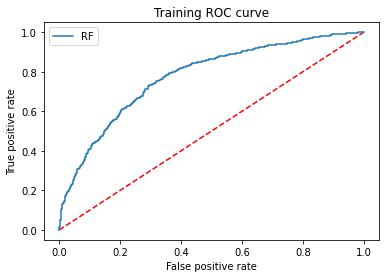

In [0]:
##############################################################################
# Training Metrics
##############################################################################

y_pred_rf = rf.predict_proba(np.nan_to_num(X_train))[:, 1]
y_pred = rf.predict(np.nan_to_num(X_train))

fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)

rf_t_auc = roc_auc_score(y_train, y_pred_rf)

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Training ROC curve')
plt.legend(loc='best')
plt.show()

Train ROC AUC=0.776
Test ROC AUC=0.738


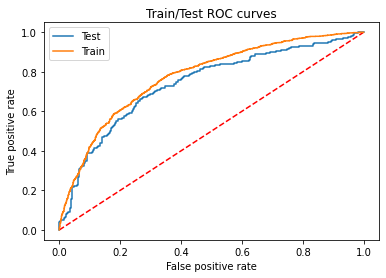

              precision    recall  f1-score   support

           0       0.69      0.69      0.69       346
           1       0.70      0.69      0.70       356

    accuracy                           0.69       702
   macro avg       0.69      0.69      0.69       702
weighted avg       0.69      0.69      0.69       702

Confusion Matrix
[[239 107]
 [109 247]]

Accuracy
0.6923076923076923


In [26]:
##############################################################################
# Classifier validation: RF with Validation Metrics
##############################################################################
y_pred_rf = rf.predict_proba(np.nan_to_num(X_train))[:, 1]
y_pred = rf.predict(np.nan_to_num(X_train))

fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)

rf_t_auc = roc_auc_score(y_train, y_pred_rf)


##### Validation Metrics #####

y_pred_rf = rf.predict_proba(np.nan_to_num(X_test))[:, 1]
y_pred = rf.predict(np.nan_to_num(X_test))

vfpr_rf, vtpr_rf, _ = roc_curve(y_test, y_pred_rf)


rf_v_auc = roc_auc_score(y_test, y_pred_rf)

print('Train ROC AUC=%.3f' % (rf_t_auc))
print('Test ROC AUC=%.3f' % (rf_v_auc))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(vfpr_rf, vtpr_rf, label='Test')
plt.plot(fpr_rf, tpr_rf, label='Train')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Train/Test ROC curves')
plt.legend(loc='best')
plt.show()
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))


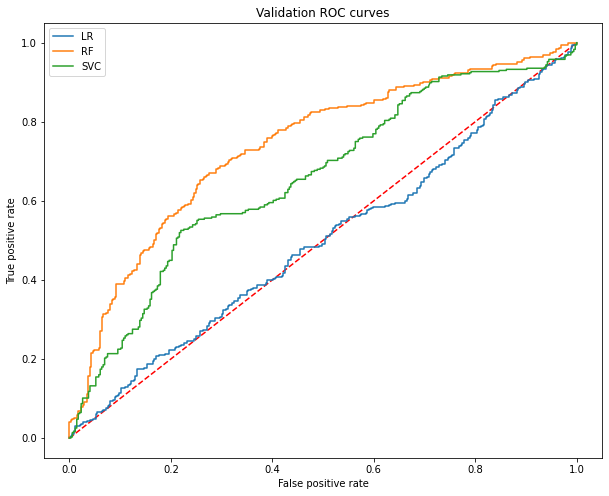

Random Forest ROC AUC            0.738
Support Vector Machine ROC AUC   0.658
Logistic Regression ROC AUC      0.497


In [27]:
##############################################################################
# Classifier validation: Comparison
##############################################################################
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(vfpr_rf, vtpr_rf, label='RF')
plt.plot(fpr_svc, tpr_svc, label='SVC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Validation ROC curves')
plt.legend(loc='best')
plt.show()


print('Random Forest ROC AUC            %.3f' % (rf_v_auc))
print('Support Vector Machine ROC AUC   %.3f' % (svc_v_auc))
print('Logistic Regression ROC AUC      %.3f' % (lr_v_auc))

In [28]:
##############################################################################
# Primary model on validation time-span
##############################################################################
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc(X_test.index.min())
end = primary_forecast.index.get_loc(X_test.index.max()) + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       346
           1       0.51      1.00      0.67       356

    accuracy                           0.51       702
   macro avg       0.25      0.50      0.34       702
weighted avg       0.26      0.51      0.34       702

Confusion Matrix
[[  0 346]
 [  0 356]]

Accuracy
0.5071225071225072


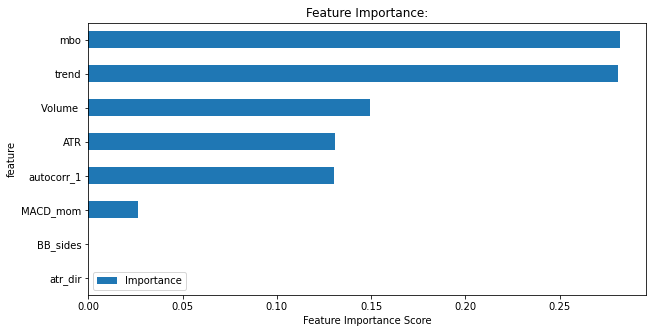

In [29]:
###############################################################################
# Feature Importance
###############################################################################
title = 'Feature Importance:'
figsize = (10, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')

plt.show()

In [30]:
# getting daily returns from intraday returns, needed for pyfolio
def get_daily_returns(intraday_returns):              
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

# For using Trend-Scanning Labeling instead of TBL
valid_dates = X_test.index
trend2 = trend.copy()
trend2["ret"] = trend.tVal*0.0001

###############################################################################
# "In-Sample" (Validation set) Trading Performance
###############################################################################

# Without meta-labeling

# Downsample to daily
prim0_rets_test = labels.loc[valid_dates, 'ret']        # use trend2 in place of labels for trend-scanning labeling
daily_rets_prim0 = get_daily_returns(prim0_rets_test)

pf.show_perf_stats(daily_rets_prim0)

Start date,2019-10-15
End date,2019-12-31
Total months,2
,Backtest
Annual return,-18.3%
Cumulative returns,-4.4%
Annual volatility,9.8%
Sharpe ratio,-2.02
Calmar ratio,-3.40
Stability,0.46
Max drawdown,-5.4%


In [31]:
# With meta-labeling
prim1_rets_test = labels.loc[valid_dates, 'ret'] * y_pred
daily_rets_prim1 = get_daily_returns(prim1_rets_test)

pf.show_perf_stats(daily_rets_prim1)

#pf.show_perf_stats(labels.loc[valid_dates, 'ret'] * y_pred)

Start date,2019-10-15
End date,2019-12-31
Total months,2
,Backtest
Annual return,184.2%
Cumulative returns,26.1%
Annual volatility,8.7%
Sharpe ratio,12.07
Calmar ratio,344.41
Stability,0.95
Max drawdown,-0.5%


              precision    recall  f1-score   support

           0       0.65      0.67      0.66       809
           1       0.70      0.69      0.69       912

    accuracy                           0.68      1721
   macro avg       0.68      0.68      0.68      1721
weighted avg       0.68      0.68      0.68      1721

Confusion Matrix
[[541 268]
 [287 625]]

Accuracy
0.6775130737943056


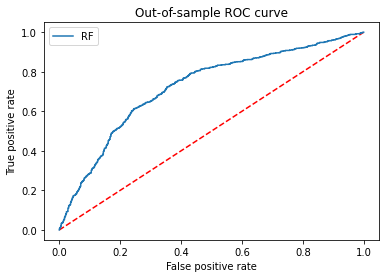

In [32]:
###############################################################################
# Out-of-Sample Testing
###############################################################################
# Extracting out-of-sample data (forward-test)
X_forward = X['2020-01-02':'2020-04-30']
y_forward = y['2020-01-02':'2020-04-30']

# Performance Metrics
y_pred_rf = rf.predict_proba(np.nan_to_num(X_forward))[:, 1]
y_pred = rf.predict(np.nan_to_num(X_forward))
fpr_rf, tpr_rf, _ = roc_curve(np.nan_to_num(y_forward), y_pred_rf)
print(classification_report(np.nan_to_num(y_forward), y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_forward, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_forward, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Out-of-sample ROC curve')
plt.legend(loc='best')
plt.show()

In [33]:
# Primary model out-of-sample
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast['2020-01-02':'2020-04-30']

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       809
           1       0.53      1.00      0.69       912

    accuracy                           0.53      1721
   macro avg       0.26      0.50      0.35      1721
weighted avg       0.28      0.53      0.37      1721

Confusion Matrix
[[  0 809]
 [  0 912]]

Accuracy
0.5299244625217897


In [0]:
import yfinance as yf

sp500 = yf.Ticker("^GSPC")

# get benchmark data
bench = sp500.history(period='ytd')
bench['S&P 500'] =(bench['Close'].diff())*0.001
bench_ret = bench['S&P 500']

In [46]:
## TEMPORARY CELL (for plotting both stats together)
fwd_test_dates = X_forward.index

# Downsample to daily
prim_rets_test = labels.loc[fwd_test_dates, 'ret']
daily_rets_prim = get_daily_returns(prim_rets_test)

pf.show_perf_stats(daily_rets_prim)
# pf.show_perf_stats(labels.loc[fwd_test_dates, 'ret'])
# pf.create_returns_tear_sheet(daily_rets_prim, benchmark_rets=None)

# With meta-labeling
print("\n \n With meta-labeling:")

meta_returns = labels.loc[fwd_test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

pf.show_perf_stats(daily_rets_meta)



Start date,2020-01-03
End date,2020-04-30
Total months,4
,Backtest
Annual return,-12.4%
Cumulative returns,-4.4%
Annual volatility,19.3%
Sharpe ratio,-0.59
Calmar ratio,-0.89
Stability,0.01
Max drawdown,-13.9%



 
 With meta-labeling:


Start date,2020-01-03
End date,2020-04-30
Total months,4
,Backtest
Annual return,783.6%
Cumulative returns,108.5%
Annual volatility,22.3%
Sharpe ratio,9.94
Calmar ratio,575.61
Stability,0.87
Max drawdown,-1.4%


Start date,2020-01-03
End date,2020-04-30
Total months,4
,Backtest
Annual return,-12.4%
Cumulative returns,-4.4%
Annual volatility,19.3%
Sharpe ratio,-0.59
Calmar ratio,-0.89
Stability,0.01
Max drawdown,-13.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.91,2020-03-26,2020-04-20,NaT,NaN
1,7.42,2020-01-08,2020-03-09,2020-03-18,51
2,1.64,2020-03-23,2020-03-24,2020-03-25,3
3,0.01,2020-01-03,2020-01-06,2020-01-07,3
4,0.00,2020-01-03,2020-01-03,2020-01-03,1


Stress Events,mean,min,max
New Normal,-0.05%,-3.21%,4.35%


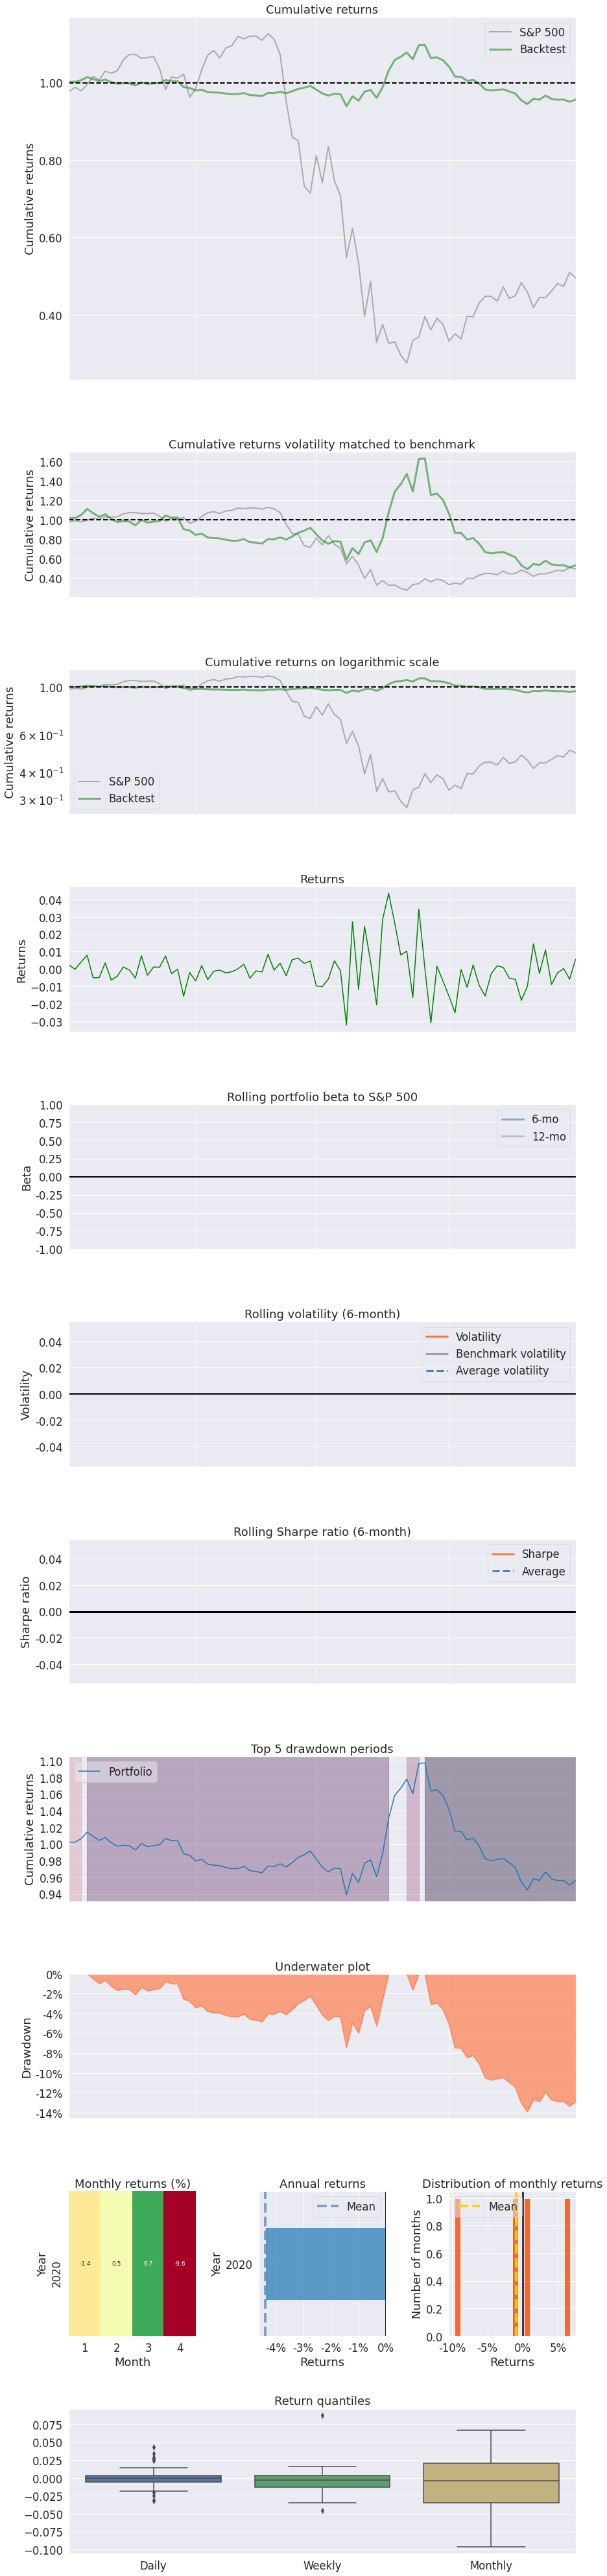

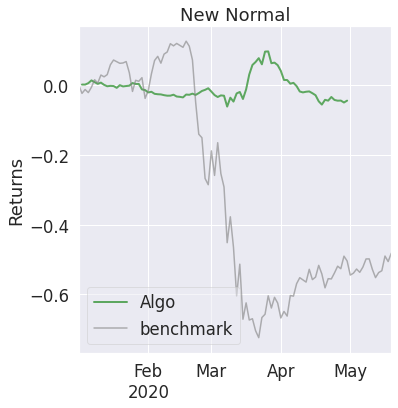

In [36]:
###############################################################################
# Out-of-Sample Trading Performance
###############################################################################
# Without meta-labeling

fwd_test_dates = X_forward.index

# Downsample to daily
prim_rets_test = labels.loc[fwd_test_dates, 'ret']
daily_rets_prim = get_daily_returns(prim_rets_test)

#pf.show_perf_stats(daily_rets_prim)
# pf.show_perf_stats(labels.loc[fwd_test_dates, 'ret'])
pf.create_full_tear_sheet(daily_rets_prim, round_trips = False, benchmark_rets=bench_ret)

In [0]:
# "SIMULATION"
#labels_bckup = labels.copy()
commission = 0.00006
avg_spread = 0.00008
labels["net_ret"] = labels.ret-commission-avg_spread

In [38]:
labels['2020-01-02':'2020-04-30'].count(axis=0)

ret     1721
trgt    1721
bin     1721
side    1721
dtype: int64

Start date,2020-01-03
End date,2020-04-30
Total months,4
,Backtest
Annual return,783.6%
Cumulative returns,108.5%
Annual volatility,22.3%
Sharpe ratio,9.94
Calmar ratio,575.61
Stability,0.87
Max drawdown,-1.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.36,2020-01-29,2020-01-30,2020-02-05,6
1,1.05,2020-04-16,2020-04-17,2020-04-21,4
2,0.77,2020-04-08,2020-04-09,2020-04-13,4
3,0.70,2020-01-21,2020-01-22,2020-01-24,4
4,0.58,2020-04-23,2020-04-24,2020-04-27,3


Stress Events,mean,min,max
New Normal,0.88%,-1.36%,5.92%


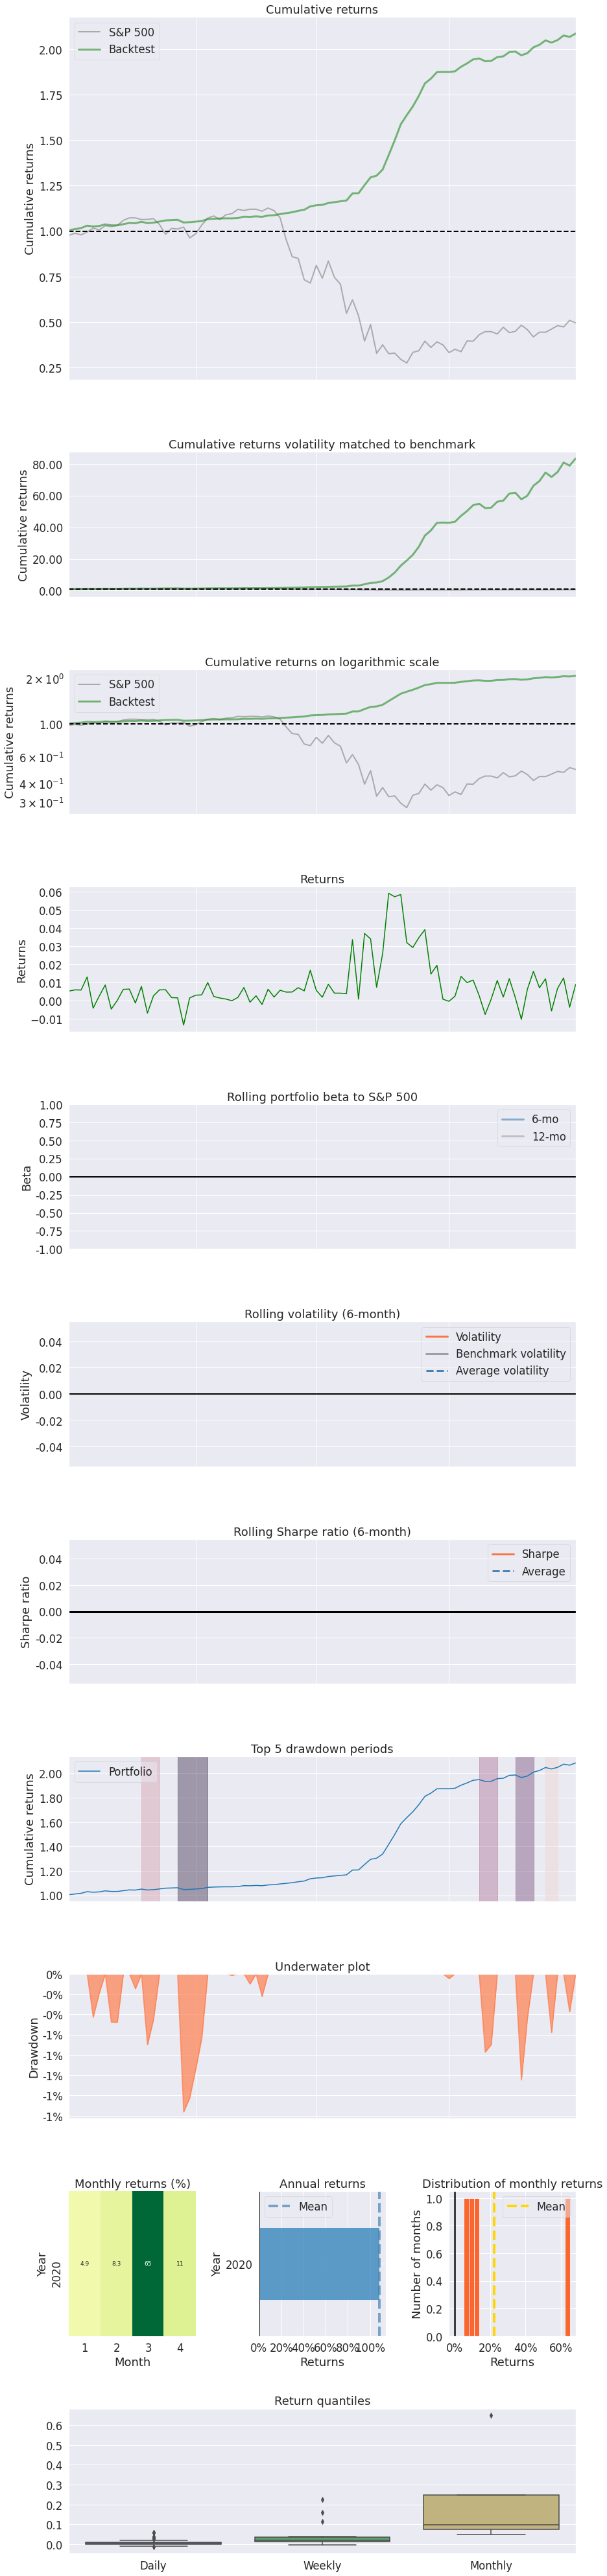

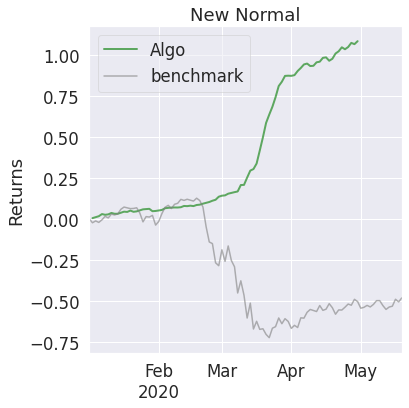

In [48]:
# With meta-labeling

warnings.filterwarnings("ignore")

meta_returns = labels.loc[fwd_test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_full_tear_sheet(daily_rets_meta, round_trips = False, benchmark_rets=bench_ret)

In [0]:
ticks = pd.read_csv('https://capital20.com/WQU_CapstoneData/GBPUSD_Ticks_2020.05.01_2020.05.19.csv')

In [0]:
ticks0 = pd.DataFrame(columns = ['date_time', 'price', 'volume'])
ticks0['date_time'] = ticks['Time (UTC)']
ticks0['price'] = ticks['Bid']
ticks0['volume'] = ticks['BidVolume']
ticks0

,date_time,price,volume
0,2020.05.01 00:00:00.147,1.25805,1.00
1,2020.05.01 00:00:00.298,1.25803,1.00
2,2020.05.01 00:00:00.349,1.25801,1.00
3,2020.05.01 00:00:00.400,1.25801,1.00
4,2020.05.01 00:00:00.502,1.25801,1.00
...,...,...,...
1283892,2020.05.19 12:52:00.279,1.22296,1.57
1283893,2020.05.19 12:52:00.381,1.22299,1.50
1283894,2020.05.19 12:52:00.482,1.22300,1.00
1283895,2020.05.19 12:52:00.533,1.22301,1.10


In [44]:
###############################################################################
# Data Structuring
###############################################################################
# Counting observations
rr = pd.read_csv('https://capital20.com/WQU_CapstoneData/GBPUSD_TickBar_500_Bid_2019.01.02_2020.05.13.csv')
rr.index = pd.to_datetime(rr['Time (UTC)'])
rr = rr.drop(['Time (UTC)', 'EndTime'], axis=1)
rr['2019-01-02':'2020-04-30']
rr_tot = len(rr.index)
rr_ins = len(rr['2019-01-02':'2019-12-31'].index)
rr_oos = int(rr_tot-rr_ins)
rr_train = int(rr_ins*0.8)
rr_test = int(rr_ins*0.2)

print('Number of data points:')
print('Total: %.3f' % (rr_tot))
print('Train set: %.3f' % (rr_train))
print('Validation set: %.3f' % (rr_test))
print('OOS Test set: %.3f' % (rr_oos))

Number of data points:
Total: 87026.000
Train set: 48955.000
Validation set: 12238.000
OOS Test set: 25832.000


In [0]:
# Creating custom bars
from mlfinlab.data_structures import standard_data_structures

#time_bars = standard_data_structures.get_time_bars(ticks0, threshold=5500, batch_size=1000000, resolution = 'H', num_units=1, verbose=False)
tick_bars = standard_data_structures.get_tick_bars(ticks0, threshold=500, batch_size=1000000, verbose=False)
volume_bars = standard_data_structures.get_volume_bars(ticks0, threshold=1000, batch_size=1000000, verbose=False)
dollar_bars = standard_data_structures.get_volume_bars(ticks0, threshold=900, batch_size=1000000, verbose=False)

In [0]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

In [0]:
time_bars = pd.read_csv('https://capital20.com/WQU_CapstoneData/GBPUSD_5Mins_Bid_2020.05.01_2020.05.19.csv', index_col='Time (UTC)')

time_bars.index = pd.to_datetime(time_bars.index)
tick_bars.index = pd.to_datetime(tick_bars.index)
volume_bars.index = pd.to_datetime(volume_bars.index)
dollar_bars.index = pd.to_datetime(dollar_bars.index)

In [0]:
###############################################################################
# AC Analysis
###############################################################################
time_returns = np.log(time_bars['Close']).diff().dropna()
tick_returns = np.log(tick_bars['close']).diff().dropna()
volume_returns = np.log(volume_bars['close']).diff().dropna()
dollar_returns = np.log(dollar_bars['close']).diff().dropna()

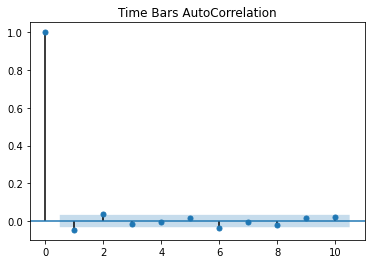

In [0]:
plot_acf(time_returns, lags=10)
plt.title('Time Bars AutoCorrelation')
plt.show()

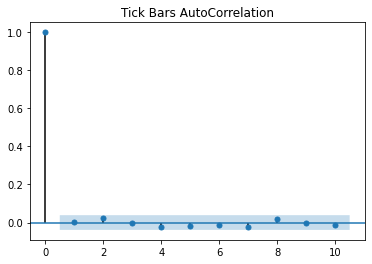

In [0]:
plot_acf(tick_returns, lags=10)
plt.title('Tick Bars AutoCorrelation')
plt.show()

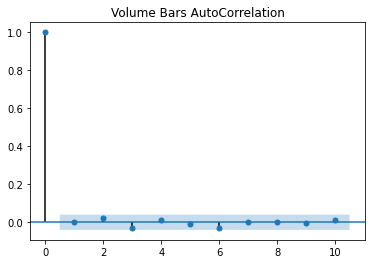

In [0]:
plot_acf(volume_returns, lags=10)
plt.title('Volume Bars AutoCorrelation')
plt.show()

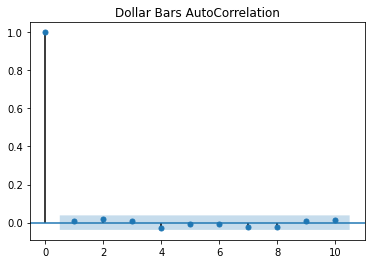

In [0]:
plot_acf(dollar_returns, lags=10)
plt.title('Dollar Bars AutoCorrelation')
plt.show()

In [0]:
###############################################################################
# Jarque-Bera Test, Normality
###############################################################################
from scipy import stats

In [0]:
print ('Test Statistics:')
print ('Time:', '\t', stats.jarque_bera(time_returns))
print ('Tick:', '\t', stats.jarque_bera(tick_returns))
print ('Volume:', stats.jarque_bera(volume_returns))
print ('Dollar:', stats.jarque_bera(dollar_returns))

Test Statistics:
Time: 	 (4010.895460375833, 0.0)
Tick: 	 (64.80119825030046, 8.43769498715119e-15)
Volume: (125.11752372184269, 0.0)
Dollar: (70.45158339715121, 5.551115123125783e-16)


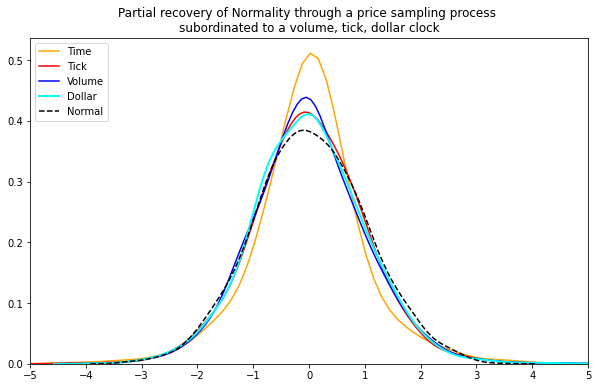

In [0]:
# Calculate the differences
time_diff = time_returns
tick_diff = tick_returns
volume_diff = volume_returns
dollar_diff = dollar_returns

# Standardize the data
time_standard = (time_diff - time_diff.mean()) / time_diff.std()
tick_standard = (tick_diff - tick_diff.mean()) / tick_diff.std()
volume_standard = (volume_diff - volume_diff.mean()) / volume_diff.std()
dollar_standard = (dollar_diff - dollar_diff.mean()) / dollar_diff.std()

# Plot the Distributions
plt.figure(figsize=(10,6))
sns.kdeplot(time_standard, label="Time", bw=0.30, color='orange')
sns.kdeplot(tick_standard, label="Tick", bw=0.25, color='red')
sns.kdeplot(volume_standard, label="Volume", bw=0.25, color='blue')
sns.kdeplot(dollar_standard, label="Dollar", bw=0.25, linewidth=2, color='cyan')

sns.kdeplot(np.random.normal(size=len(volume_returns)), label="Normal", color='black', linestyle="--")

plt.xticks(range(-5, 6))
plt.legend(loc='upper left')
plt.title('Partial recovery of Normality through a price sampling process \nsubordinated to a volume, tick, dollar clock',
          loc='center')
plt.xlim(-5, 5)
plt.show()